## Import Libraries

In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)


## Model Variables

In [29]:
features = ['Open', 'High', 'Low', 'Volume']
target   = 'target'
rolling_window = 50 

## Data Pre-Processing

In [49]:
df = pd.read_csv("../filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target']     = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

## Dataset Split

In [50]:
# 2. Static 60/20/20 split
n_total  = len(df)
n_train  = int(0.6 * n_total)
n_val    = int(0.2 * n_total)

train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:n_train+n_val]
test_df  = df.iloc[n_train+n_val:].reset_index(drop=True)

## Feature Extraction & Scaling

In [51]:
scaler       = StandardScaler().fit(train_df[features])
X_train_s    = scaler.transform(train_df[features])
X_val_s      = scaler.transform(val_df[features])
y_train_arr  = train_df['target'].values
y_val_arr    = val_df['target'].values

## Create RNN Sequences

In [52]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_arr, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_s,   y_val_arr,   rolling_window)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq:", X_val_seq.shape,   y_val_seq.shape)

Train seq: (45220, 50, 4) (45220,)
Val   seq: (15040, 50, 4) (15040,)


In [53]:
n_features = X_train_seq.shape[2]
model = Sequential([
    SimpleRNN(64, input_shape=(rolling_window, n_features)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'],
)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=32,
    verbose=1     # <-- now you’ll see per‐epoch timings & val metrics
)

Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 269/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5001 - loss: 0.7191

KeyboardInterrupt: 

## Base RNN Model
Rolling window test across every year

In [35]:
# 6. Per‑year rolling‑window TEST (same as before)
test_df['Year']     = test_df['Date'].dt.year
unique_years       = sorted(test_df['Year'].unique())
all_y_true, all_y_pred, all_y_proba = [], [], []
all_test_dates = []

for year in unique_years:
    year_test = test_df[test_df['Year']==year].reset_index(drop=True)
    # scale & sequence
    Xt_s, yt_arr = (
        scaler.transform(year_test[features]),
        year_test['target'].values
    )
    Xt_seq, yt_seq = create_sequences(Xt_s, yt_arr, rolling_window)
    if Xt_seq.size == 0:
        continue

    # predict
    proba = model.predict(Xt_seq).ravel()
    pred  = (proba > 0.5).astype(int)

    all_y_true.extend(yt_seq.tolist())
    all_y_pred.extend(pred.tolist())
    all_y_proba.extend(proba.tolist())
    all_test_dates.extend(year_test['Date'].iloc[rolling_window:].tolist())

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Evaluation


Rolling‑Window RNN Results:
Accuracy: 0.5172
F1 Score:  0.6750
AUC‑ROC:   0.5099

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down             238          6979
Actual Up               258          7515


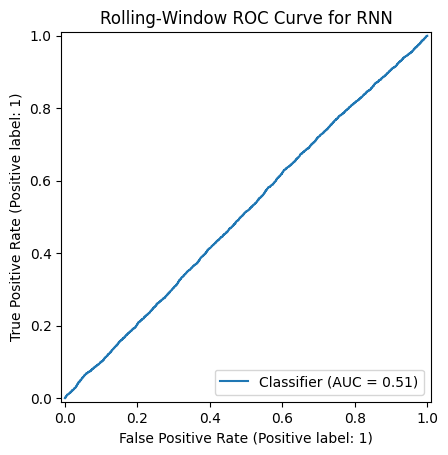

In [36]:
accuracy = accuracy_score(all_y_true, all_y_pred)
f1       = f1_score(all_y_true, all_y_pred)
auc      = roc_auc_score(all_y_true, all_y_proba)
cm       = confusion_matrix(all_y_true, all_y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for RNN')
plt.show()

## Best RNN Model
Basic RNN after running autotuner

In [54]:
def build_rnn_model(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            input_shape=(rolling_window, len(features))
        ),
        Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2) Prepare your static 60/20/20 split if not already done:
n = len(df)
n_train = int(0.6*n)
n_val   = int(0.2*n)
train_df = df.iloc[:n_train]
test_df  = df.iloc[n_train+n_val:].copy()
test_df['Year'] = test_df['Date'].dt.year
unique_years = sorted(test_df['Year'].unique())

# 3) The custom Tuner subclass:
class BacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_model(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            year_test = test_df[test_df['Year']==year]
            # build year_train same as before:
            if idx == 0:
                year_train = train_df
            else:
                cutoff = year_test['Date'].min()
                up_to = df[df['Date'] < cutoff]
                size = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            # scale
            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            # sequences
            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if X_tr_seq.size == 0 or X_te_seq.size == 0:
                continue

            # train for fixed epochs
            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )

            # eval
            y_pred = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, y_pred))

        # average across years
        mean_acc = np.mean(year_accs) if year_accs else 0.0
        # report back to the tuner
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# 4) Run the search
tuner = BacktestTuner(
    hypermodel=build_rnn_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    directory='rnn_backtest_tuner',
    project_name='rb_tuner'
)

tuner.search()  # no (X,y) passed; run_trial handles everything

Trial 10 Complete [00h 01m 22s]
val_accuracy: 0.49869048396577625

Best val_accuracy So Far: 0.5164376918555287
Total elapsed time: 00h 17m 14s


### Evaluation

In [59]:
# 1. Fetch the best model from the tuner
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_rnn_model(best_hp)

#    You can train on just the original train set, or on train+val combined:
X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,              # use the same number of epochs you tuned with
    batch_size=32,
    verbose=1
)

# 4. Finally, predict on your test sequences
y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1884/1884 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5017 - loss: 0.7161
Epoch 2/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.5081 - loss: 0.7060
Epoch 3/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5058 - loss: 0.7010
Epoch 4/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.5107 - loss: 0.6975
Epoch 5/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5120 - loss: 0.6973
Epoch 6/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.5127 - loss: 0.6948
Epoch 7/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5163 - loss: 0.6938
Epoch 8/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5281 - loss: 0.6922
Epoch 9/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5292 - loss: 0.6915
Epoch 10/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5364 - loss: 0.6898
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5351
F1 Score:  0.6769
AUC‑ROC:   0.5642

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down             605          5370
Actual Up               464          6111


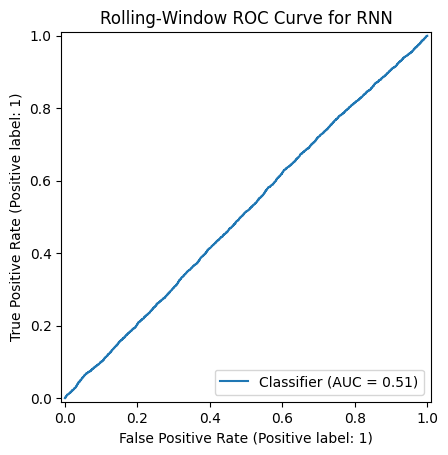

In [61]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for RNN')
plt.show()